# Visualising "closeness" of current members of parliament based on how they vote in divisions

We're going to use the similarity measure from They Vote For You on all current members of parliament and then use multi-dimensional scaling (MDS) to create a two dimensional "map" of all the members where their position on the map puts them close to other members who they voted similarly to and far away from those they voted very differently to.

One possible improvement for the future is to use the "strong" votes from policies to weight certain divisions more strongly than others in the calculation of similarity. Those would be divisions that related to actual concrete changes in the law (otherwise known as substantive changes).

We can't get the data we need directly through the They Vote For You API right now so we're going to get it by running a special "rake" task (see https://github.com/openaustralia/theyvoteforyou/blob/b2faeb984c5cbc4c67577f8023d15a59480f59d0/lib/tasks/application.rake#L217)

Loading the exported csv...

In [1]:


representatives_distances = _deepnote_execute_sql("""SELECT *
FROM '/work/representatives_distances.csv' ORDER BY person1_id, person2_id;
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
representatives_distances

,person1_id,person2_id,distance_b
0,10007,10007,0.000000
1,10007,10014,0.996044
2,10007,10043,0.000000
3,10007,10060,0.000826
4,10007,10069,0.990121
...,...,...,...
22495,10963,10940,0.000000
22496,10963,10941,0.785124
22497,10963,10942,0.011152
22498,10963,10960,0.980843


In [2]:


representatives_people = _deepnote_execute_sql("""SELECT *
FROM '/work/representatives_people.csv' ORDER by id
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
representatives_people

,id,name,party
0,10007,Anthony Albanese,Australian Labor Party
1,10014,Kevin Andrews,Liberal Party
2,10043,Sharon Bird,Australian Labor Party
3,10060,Chris Bowen,Australian Labor Party
4,10069,Russell Broadbent,Liberal Party
...,...,...,...
145,10940,James Stevens,Liberal Party
146,10941,Zali Steggall,Independent
147,10942,Dave Sharma,Liberal Party
148,10960,Kristy McBain,Australian Labor Party


In this visualisation we want to look at the coalition as one party and we have to deal with an implementation detail of the data from They Vote For You where the speaker and their deputy are listed as being in their own "party". We'll also need to convert them to the more intuitive understanding of what "party" is.

In [3]:
def tvfy_party_convert(party):
    # My understanding is the Country Liberal Party is not strictly part of the coalition but
    # members do join the party rooms of coalition members at the Federal level.
    if party == "Liberal Party" or party == "National Party" or party == "Liberal National Party" or party == "Country Liberal Party":
        return "Coalition"
    elif party == "Australian Labor Party":
        return "ALP"
    elif party == "Pauline Hanson's One Nation Party":
        return "One Nation"
    elif party == "Australian Greens":
        return "Greens"
    elif party == "Katter's Australian Party":
        return "Katter's Australian"
    elif party == "United Australia Party":
        return "United Australia"
    # The speaker and the deputy speaker are members of the liberal
    # and national party respectively so we'll label them the same as the coalition
    # The president and deputy president of the senate are liberal and ALP members respectively
    elif party == "SPK" or party == "CWM" or party == "PRES":
        return "Coalition"
    elif party == "DPRES":
        return "ALP"
    # Ones where we don't want to change the name
    elif party == "Jacqui Lambie Network" or party == "Centre Alliance" or party == "Independent":
        return party
    else:
        raise NameError(f"{party} unsupported currently")
        
representatives_people["party"] = representatives_people["party"].map(tvfy_party_convert)


First let's import the libraries that we're going to use. We're going to use scikit to do the multi-dimensional scaling calculation and matplotlib for plotting

In [4]:
from sklearn.manifold import MDS
from matplotlib import pyplot as plt
import pandas as pd

We need to turn this into a square matrix. We'll also need another array that converts between the index in the matrix and the `person_id`. Now that we have a matrix of the distances we can plug that into the metric MDS algorithm to get the points transformed to a 2d plane.

In [5]:
def calculate_mds(distances, people):
    dist_matrix = distances.pivot(index='person1_id', columns='person2_id', values='distance_b')
    mds = MDS(metric=True, dissimilarity='precomputed', random_state=0, eps=1e-10, max_iter=5000)
    f = mds.fit_transform(dist_matrix)
    transformed = pd.DataFrame(f, columns=["x", "y"])
    transformed["id"] = people["id"]
    transformed["name"] = people["name"]
    transformed["party"] = people["party"]
    return transformed

representatives_transformed = calculate_mds(representatives_distances, representatives_people)
# Flip everything in the X direction just to not make this a left-right thing
representatives_transformed["x"] = representatives_transformed["x"].map(lambda x: -x)

Now let's plot the result

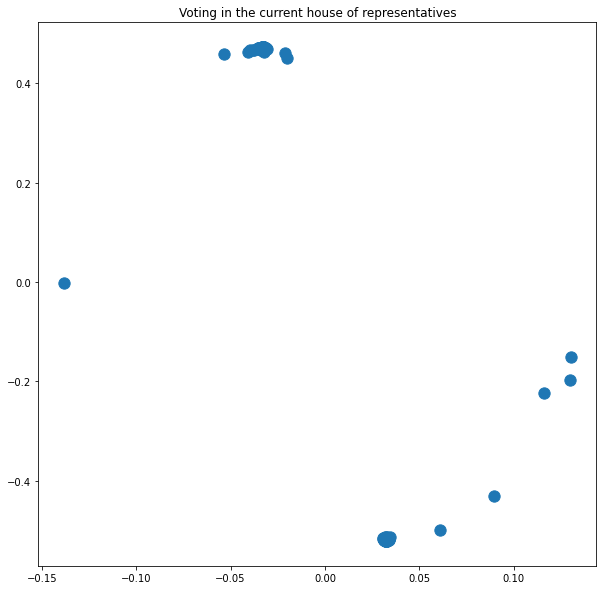

In [6]:
fig = plt.figure(2, (10,10))
plt.scatter(representatives_transformed["x"], representatives_transformed["y"], s=128)
plt.title('Voting in the current house of representatives')
plt.show()

To make this more useful let's colour in each point with the colour of the party that the person is currently a member of. Let's start with some party colours (taken from https://en.wikipedia.org/wiki/Template:Australian_politics/party_colours)

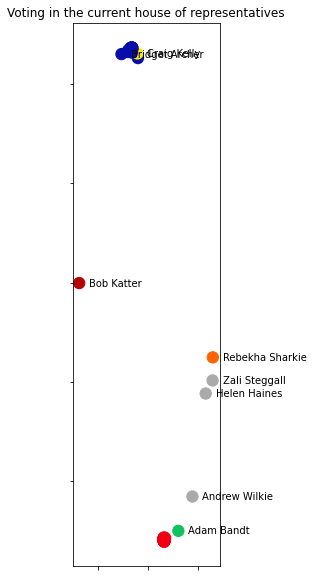

In [7]:
def party_to_colour(party):
    party_colours = {
        "Coalition": "#080CAB",
        "ALP": "#F00011",
        "Greens": "#10C25B",
        "Katter's Australian": "#B50204",
        "Centre Alliance": "#ff6300",
        "United Australia": "#FFED00",
        "One Nation": "#f36c21",
        "Jacqui Lambie Network": "#FFCB08",
        # TODO: What colour for the independents?
        "Independent": "#aaa",
    }
    return party_colours[party]

representatives_transformed["colours"] = representatives_transformed["party"].map(party_to_colour)

fig, ax = plt.subplots(figsize=(10, 10))
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.scatter(representatives_transformed["x"], representatives_transformed["y"], c=representatives_transformed["colours"], s=128)

# for i, txt in enumerate(people["name"]):
#     ax.annotate(txt, (x[i], y[i]), xytext=(10,-3), textcoords="offset pixels")

def label(ax, name):
    i = list(representatives_transformed["name"]).index(name)
    ax.annotate(name, (representatives_transformed["x"][i], representatives_transformed["y"][i]), xytext=(10,-3), textcoords="offset pixels")

# Just label ones that are not just in a big clump
label(ax, "Adam Bandt")
label(ax, "Bob Katter")
label(ax, "Andrew Wilkie")
label(ax, "Helen Haines")
label(ax, "Rebekha Sharkie")
label(ax, "Zali Steggall")
label(ax, "Bridget Archer")
label(ax, "Craig Kelly")

plt.title('Voting in the current house of representatives')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [8]:
def plot_zoomed(transformed, x0, x1, y0, y1, title="Zoomed in area", show_ticks=False):
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.xticks(visible=show_ticks)
    plt.yticks(visible=show_ticks)
    plt.scatter(transformed["x"], transformed["y"], c=transformed["colours"], s=128)

    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)

    for i, txt in enumerate(transformed["name"]):
        ax.annotate(txt, (transformed["x"][i], transformed["y"][i]), xytext=(10,-3), textcoords="offset pixels")
    
    plt.title(title)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

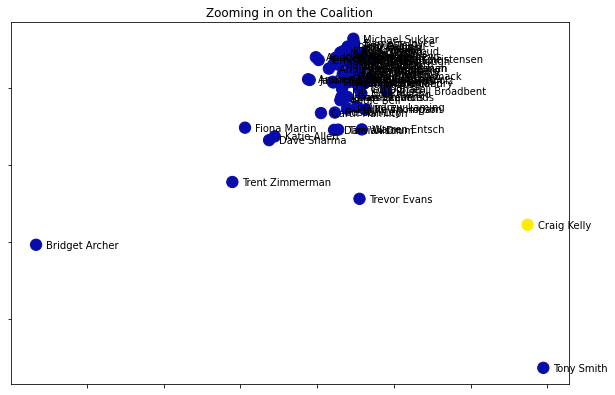

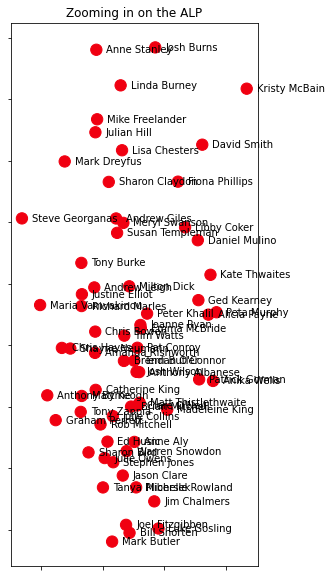

In [9]:
def zoom_to_party(transformed, party, title="Zooming in on one party", show_ticks=False):
    f = transformed[transformed["party"] == party]
    x0 = min(f["x"])
    x1 = max(f["x"])
    y0 = min(f["y"])
    y1 = max(f["y"])

    # Make it 10% wider so people are not right at the edge of the plot
    cx = 0.5 * (x0 + x1)
    cy = 0.5 * (y0 + y1)
    
    x0 = cx - 1.1 * (cx - x0)
    x1 = cx + 1.1 * (x1 - cx)
    y0 = cy - 1.1 * (cy - y0)
    y1 = cy + 1.1 * (y1 - cy)

    plot_zoomed(transformed, x0, x1, y0, y1, title, show_ticks)
    
zoom_to_party(representatives_transformed, "Coalition", title="Zooming in on the Coalition")
zoom_to_party(representatives_transformed, "ALP", title="Zooming in on the ALP")


It would be interesting to see what this looked like if you coloured things by the faction. The faction is a sub-grouping within the party. I hand-annotated the people with their faction as listed in public sources like wikipedia and this article by James Massola in the SMH https://www.smh.com.au/politics/federal/what-are-labor-s-factions-and-who-s-who-in-the-left-and-right-20210210-p5718j.html

In [10]:


factions = _deepnote_execute_sql("""SELECT * from '/work/visualise-votes-mds/factions.csv' ORDER BY id
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
factions

,id,name,party,faction
0,10007,Anthony Albanese,Australian Labor Party,left
1,10043,Sharon Bird,Australian Labor Party,right
2,10060,Chris Bowen,Australian Labor Party,right
3,10081,Tony Burke,Australian Labor Party,right
4,10086,Mark Butler,Australian Labor Party,left
...,...,...,...,...
62,10926,Fiona Phillips,Australian Labor Party,left
63,10930,Kate Thwaites,Australian Labor Party,left
64,10931,Anika Wells,Australian Labor Party,right
65,10934,Josh Burns,Australian Labor Party,right


Merge the factions data into the main people data

In [11]:
factions["party"] = factions["party"].map(tvfy_party_convert)
representatives_people = pd.merge(representatives_people, factions, how="left")
representatives_people['faction'] = representatives_people['faction'].fillna("unknown")

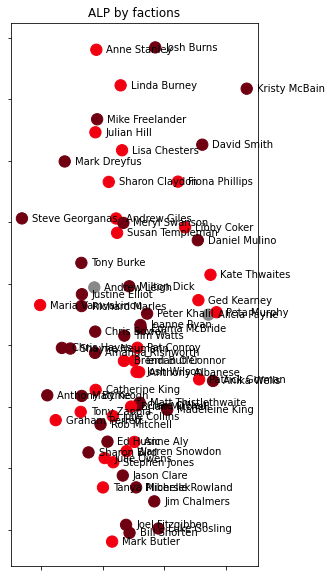

In [12]:
def faction_to_colour(faction):
    faction_colours = {
        # Do the factions have "official" colours? I'll just make some up
        "left": "#F00011",
        "right": "#700011",
        "unknown": "#aaa",
        "unaligned": "#888",
    }
    return faction_colours[faction]

representatives_transformed["colours"] = representatives_people["faction"].map(faction_to_colour)
zoom_to_party(representatives_transformed, "ALP", title="ALP by factions")

Well that's a bit surprising! The factions don't seem to be all that much connected to how they vote. Thinking further could this be because "free" votes, where ALP members are allowed to vote differently to each other are largely on social issues and "ethical" issues. Are the factions instead largely defined by their differences on economic issues?

## Doing it all again for the Senate

In [13]:


senate_distances = _deepnote_execute_sql("""SELECT *
FROM '/work/senate_distances.csv' WHERE person1_id NOT IN (10515, 10966) AND person2_id NOT IN (10515, 10966) ORDER BY person1_id, person2_id;
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
senate_distances

,person1_id,person2_id,distance_b
0,10003,10003,0.000000
1,10003,10044,0.016435
2,10003,10071,0.803287
3,10003,10103,0.781657
4,10003,10131,0.008716
...,...,...,...
5324,10965,10959,0.791667
5325,10965,10961,0.181818
5326,10965,10962,0.723404
5327,10965,10964,0.182796


Look closely at the distances above. You can see that there are some "-1" values in there which is obviously nonsensical. This is what's returned when two people could have voted in the same divisions but never actually did. So, we'll need to figure out how to handle this properly here.

In [14]:


senate_people = _deepnote_execute_sql("""SELECT *
FROM '/work/senate_people.csv' WHERE id NOT IN (10515, 10966) ORDER by id
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
senate_people

,id,name,party
0,10003,Eric Abetz,Liberal Party
1,10044,Simon Birmingham,Liberal Party
2,10071,Carol Brown,Australian Labor Party
3,10103,Kim Carr,Australian Labor Party
4,10131,Richard Colbeck,Liberal Party
...,...,...,...
68,10959,Andrew McLachlan,Liberal Party
69,10961,Lidia Thorpe,Australian Greens
70,10962,Ben Small,Liberal Party
71,10964,Dorinda Cox,Australian Greens


In [15]:
senate_people["party"] = senate_people["party"].map(tvfy_party_convert)

In [16]:
senate_transformed = calculate_mds(senate_distances, senate_people)

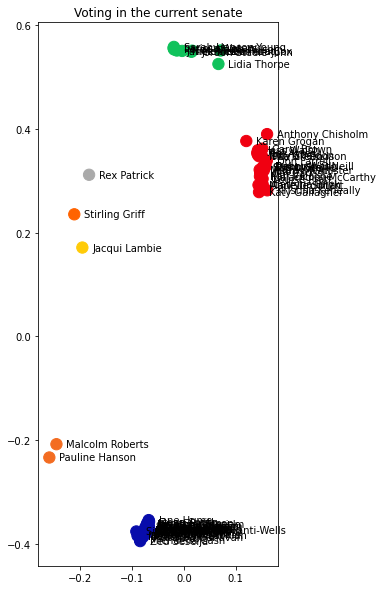

In [17]:
senate_transformed["colours"] = senate_transformed["party"].map(party_to_colour)

fig, ax = plt.subplots(figsize=(10, 10))
# plt.xticks(visible=False)
# plt.yticks(visible=False)
plt.scatter(senate_transformed["x"], senate_transformed["y"], c=senate_transformed["colours"], s=128)

for i, txt in enumerate(senate_transformed["name"]):
    ax.annotate(txt, (senate_transformed["x"][i], senate_transformed["y"][i]), xytext=(10,-3), textcoords="offset pixels")

def label(ax, name):
    i = list(people["name"]).index(name)
    ax.annotate(name, (x[i], y[i]), xytext=(10,-3), textcoords="offset pixels")

# Just label ones that are not just in a big clump
# label(ax, "Adam Bandt")
# label(ax, "Bob Katter")
# label(ax, "Andrew Wilkie")
# label(ax, "Helen Haines")
# label(ax, "Rebekha Sharkie")
# label(ax, "Zali Steggall")
# label(ax, "Bridget Archer")
# label(ax, "Craig Kelly")

plt.title('Voting in the current senate')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

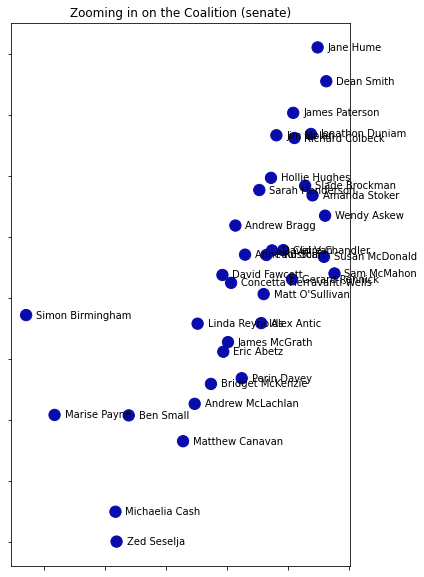

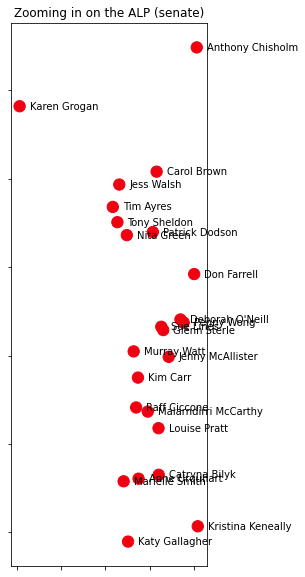

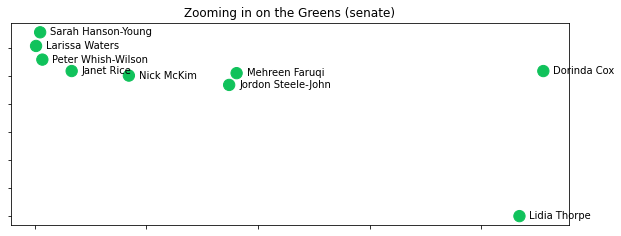

In [18]:
zoom_to_party(senate_transformed, "Coalition", title="Zooming in on the Coalition (senate)")
zoom_to_party(senate_transformed, "ALP", title="Zooming in on the ALP (senate)")
zoom_to_party(senate_transformed, "Greens", title="Zooming in on the Greens (senate)")

Dorinda Cox again hasn't been in parliament very long (only since September 2021) so that probably explains that outlier (sort of). Jordan Steele-John and Peter Whish-Wilson have both rebelled once their party while the other greens senators have not. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3cc29e64-76d4-4791-9f42-553d3a25e9a4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>